In [93]:
from raise_utils.data import DataLoader, Data
from raise_utils.learners import FeedforwardDL, DecisionTree, BiasedSVM, LogisticRegressionClassifier, NaiveBayes, RandomForest
from raise_utils.hyperparams import DODGE
from raise_utils.transform import Transform
from sklearn.decomposition import PCA
from raise_utils.metrics import ClassificationMetrics
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [59]:
df = pd.read_csv('./binary_class/data-class.csv')
df.drop(df.columns[:4], axis=1, inplace=True)

In [60]:
df.where(df != '?', np.NaN, inplace=True)

In [61]:
df.shape

(420, 62)

In [62]:
df.dropna(inplace=True)

In [63]:
df.shape

(392, 62)

In [112]:
data = Data(*train_test_split(df[df.columns[:-1]], df[df.columns[-1]]))

In [65]:
data.y_train.head()

306    False
373     True
179    False
343    False
117    False
Name: is_data_class, dtype: bool

In [66]:
sum(data.y_train) / len(data.y_train)

0.35714285714285715

In [41]:
config = {
    "n_runs": 20,
    "transforms": ["normalize", "standardize", "robust", "maxabs", "minmax"] * 30,
    "metrics": ["d2h", "pd", "pf", "accuracy", "auc"],
    "random": True,
    "learners": [],
    "log_path": "./",
    "data": [data],
    "name": "dataclass"
}
for _ in range(50):
    config["learners"].append(FeedforwardDL(weighted=True,
                                            wfo=True,
                                            random={'n_layers': (2, 6),
                                                    'n_units': (10, 70)}, 
                                            n_units=10, n_epochs=50, optimizer='adam'))

In [42]:
dodge = DODGE(config)
dodge.optimize()

{'activation': 'relu', 'hooks': None, 'learner': <raise_utils.learners.feedforward.FeedforwardDL object at 0x145be8970>, 'loss': 'binary_crossentropy', 'n_epochs': 50, 'n_layers': 2, 'n_units': 45, 'name': 'rf', 'optimizer': 'adam', 'random': {'n_layers': (2, 6), 'n_units': (10, 70)}, 'random_map': {'n_layers': (2, 6), 'n_units': (10, 70)}, 'verbose': 1, 'weighted': True, 'wfo': True, 'x_test': None, 'x_train': None, 'y_test': None, 'y_train': None}
{'activation': 'relu', 'hooks': None, 'learner': <raise_utils.learners.feedforward.FeedforwardDL object at 0x145bd1cd0>, 'loss': 'binary_crossentropy', 'n_epochs': 50, 'n_layers': 4, 'n_units': 16, 'name': 'rf', 'optimizer': 'adam', 'random': {'n_layers': (2, 6), 'n_units': (10, 70)}, 'random_map': {'n_layers': (2, 6), 'n_units': (10, 70)}, 'verbose': 1, 'weighted': True, 'wfo': True, 'x_test': None, 'x_train': None, 'y_test': None, 'y_train': None}
{'activation': 'relu', 'hooks': None, 'learner': <raise_utils.learners.feedforward.Feedforwa

minmaxR|rf
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

3/3 [==============================] - 0s 53ms/step - loss: 1.2981 - val_loss: 1.2968
Epoch 2/50
3/3 [==============================] - 0s 9ms/step - loss: 1.2938 - val_loss: 1.3062
Epoch 3/50
3/3 [==============================] - 0s 10ms/step - loss: 1.2902 - val_loss: 1.3138
Epoch 4/50
3/3 [==============================] - 0s 11ms/step - loss: 1.2866 - val_loss: 1.3196
Epoch 5/50
3/3 [==============================] - 0s 17ms/step - loss: 1.2825 - val_loss: 1.3226
Epoch 6/50
3/

Epoch 47/50
3/3 [==============================] - 0s 9ms/step - loss: 0.2735 - val_loss: 0.5567
Epoch 48/50
3/3 [==============================] - 0s 9ms/step - loss: 0.2576 - val_loss: 0.5167
Epoch 49/50
3/3 [==============================] - 0s 9ms/step - loss: 0.2423 - val_loss: 0.4797
Epoch 50/50
3/3 [==============================] - 0s 9ms/step - loss: 0.2273 - val_loss: 0.4447
3
robustq|rf
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

3/3 [==============================] - 0s 33ms/step - loss: 244126863851520.0000 - val_loss: 118

KeyboardInterrupt: 

## DIY

In [39]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras import backend as K
from keras.regularizers import l2

In [119]:
Transform('standardize').apply(data)  # normalize does not work!

In [80]:
enc_inp = Input((61,))
enc_int = Dense(30, activation='relu')(enc_inp)
enc_out = Dense(10, activation='relu')(enc_int)

dec_int = Dense(30, activation='relu')(enc_out)
dec_out = Dense(61, activation='relu')(dec_int)

autoencoder = Model(inputs=enc_inp, outputs=dec_out)

In [81]:
encoder = Model(inputs=enc_inp, outputs=enc_out)
dec_inp = Input((10,))
decoder = Model(inputs=dec_inp, outputs=autoencoder.layers[-1](autoencoder.layers[-2](dec_inp)))

In [82]:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data.x_train.astype(float), data.x_train.astype(float), epochs=500)

Epoch 1/500
10/10 [==============================] - 0s 1ms/step - loss: 0.9648
Epoch 2/500
10/10 [==============================] - 0s 1ms/step - loss: 0.9323
Epoch 3/500
10/10 [==============================] - 0s 2ms/step - loss: 0.9039
Epoch 4/500
10/10 [==============================] - 0s 1ms/step - loss: 0.8779
Epoch 5/500
10/10 [==============================] - 0s 1ms/step - loss: 0.8510
Epoch 6/500
10/10 [==============================] - 0s 2ms/step - loss: 0.8316
Epoch 7/500
10/10 [==============================] - 0s 2ms/step - loss: 0.8100
Epoch 8/500
10/10 [==============================] - 0s 2ms/step - loss: 0.7916
Epoch 9/500
10/10 [==============================] - 0s 2ms/step - loss: 0.7774
Epoch 10/500
10/10 [==============================] - 0s 2ms/step - loss: 0.7656
Epoch 11/500
10/10 [==============================] - 0s 1ms/step - loss: 0.7526
Epoch 12/500
10/10 [==============================] - 0s 2ms/step - loss: 0.7420
Epoch 13/500
10/10 [=================

10/10 [==============================] - 0s 1ms/step - loss: 0.3806
Epoch 103/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3806
Epoch 104/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3800
Epoch 105/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3785
Epoch 106/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3775
Epoch 107/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3776
Epoch 108/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3760
Epoch 109/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3757
Epoch 110/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3749
Epoch 111/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3744
Epoch 112/500
10/10 [==============================] - 0s 985us/step - loss: 0.3735
Epoch 113/500
10/10 [==============================] - 0s 941us/step - loss: 0.3728
Epoch 114/500
10/10 [=====

10/10 [==============================] - 0s 1ms/step - loss: 0.3317
Epoch 202/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3321
Epoch 203/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3312
Epoch 204/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3323
Epoch 205/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3312
Epoch 206/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3302
Epoch 207/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3301
Epoch 208/500
10/10 [==============================] - 0s 932us/step - loss: 0.3309
Epoch 209/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3312
Epoch 210/500
10/10 [==============================] - 0s 986us/step - loss: 0.3315
Epoch 211/500
10/10 [==============================] - 0s 995us/step - loss: 0.3316
Epoch 212/500
10/10 [==============================] - 0s 998us/step - loss: 0.3305
Epoch 213/500
10/10 [=

10/10 [==============================] - 0s 1ms/step - loss: 0.3197
Epoch 301/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3196
Epoch 302/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3201
Epoch 303/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3204
Epoch 304/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3202
Epoch 305/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3203
Epoch 306/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3205
Epoch 307/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3199
Epoch 308/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3194
Epoch 309/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3194
Epoch 310/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3190
Epoch 311/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3190
Epoch 312/500
10/10 [=========

10/10 [==============================] - 0s 1ms/step - loss: 0.3188
Epoch 400/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3206
Epoch 401/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3179
Epoch 402/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3170
Epoch 403/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3181
Epoch 404/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3176
Epoch 405/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3158
Epoch 406/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3159
Epoch 407/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3152
Epoch 408/500
10/10 [==============================] - 0s 998us/step - loss: 0.3151
Epoch 409/500
10/10 [==============================] - 0s 968us/step - loss: 0.3147
Epoch 410/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3148
Epoch 411/500
10/10 [=====

10/10 [==============================] - 0s 1ms/step - loss: 0.3130
Epoch 499/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3125
Epoch 500/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3120


In [83]:
main_model = Sequential([
    Dense(10, activation='selu', kernel_initializer='lecun_normal', kernel_regularizer=l2()),
    Dense(10, activation='selu', kernel_initializer='lecun_normal', kernel_regularizer=l2()),
    Dense(10, activation='selu', kernel_initializer='lecun_normal', kernel_regularizer=l2()),
    Dense(1, activation='sigmoid')
])

In [84]:
main_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [89]:
encoded = encoder(data.x_train)
hist = main_model.fit(encoded, data.y_train, 
                      validation_data=(encoder(data.x_test), data.y_test), 
                      epochs=500)

Epoch 1/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1270 - acc: 0.9796 - val_loss: 0.2624 - val_acc: 0.9388
Epoch 2/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1272 - acc: 0.9830 - val_loss: 0.2547 - val_acc: 0.9490
Epoch 3/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1295 - acc: 0.9830 - val_loss: 0.2760 - val_acc: 0.9286
Epoch 4/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1267 - acc: 0.9830 - val_loss: 0.2493 - val_acc: 0.9388
Epoch 5/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1301 - acc: 0.9796 - val_loss: 0.2553 - val_acc: 0.9490
Epoch 6/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1209 - acc: 0.9864 - val_loss: 0.2502 - val_acc: 0.9490
Epoch 7/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1217 - acc: 0.9864 - val_loss: 0.2624 - val_acc: 0.9388
Epoch 8/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1207 - a

10/10 [==============================] - 0s 4ms/step - loss: 0.1235 - acc: 0.9796 - val_loss: 0.2735 - val_acc: 0.9388
Epoch 64/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1268 - acc: 0.9796 - val_loss: 0.2482 - val_acc: 0.9490
Epoch 65/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1174 - acc: 0.9898 - val_loss: 0.2625 - val_acc: 0.9388
Epoch 66/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1132 - acc: 0.9898 - val_loss: 0.2550 - val_acc: 0.9388
Epoch 67/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1117 - acc: 0.9932 - val_loss: 0.2590 - val_acc: 0.9388
Epoch 68/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1126 - acc: 0.9898 - val_loss: 0.2643 - val_acc: 0.9388
Epoch 69/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1111 - acc: 0.9898 - val_loss: 0.2562 - val_acc: 0.9388
Epoch 70/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1122 - acc: 0

Epoch 125/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1051 - acc: 0.9932 - val_loss: 0.2878 - val_acc: 0.9388
Epoch 126/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1068 - acc: 0.9932 - val_loss: 0.2685 - val_acc: 0.9388
Epoch 127/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1049 - acc: 0.9898 - val_loss: 0.2609 - val_acc: 0.9388
Epoch 128/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1100 - acc: 0.9898 - val_loss: 0.2742 - val_acc: 0.9388
Epoch 129/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1069 - acc: 0.9898 - val_loss: 0.2766 - val_acc: 0.9388
Epoch 130/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1058 - acc: 0.9864 - val_loss: 0.2696 - val_acc: 0.9388
Epoch 131/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1038 - acc: 0.9932 - val_loss: 0.2699 - val_acc: 0.9388
Epoch 132/500
10/10 [==============================] - 0s 7ms/step - 

10/10 [==============================] - 0s 5ms/step - loss: 0.1009 - acc: 0.9898 - val_loss: 0.2749 - val_acc: 0.9388
Epoch 187/500
10/10 [==============================] - 0s 6ms/step - loss: 0.1010 - acc: 0.9898 - val_loss: 0.2907 - val_acc: 0.9388
Epoch 188/500
10/10 [==============================] - 0s 9ms/step - loss: 0.1043 - acc: 0.9932 - val_loss: 0.2894 - val_acc: 0.9286
Epoch 189/500
10/10 [==============================] - 0s 6ms/step - loss: 0.1052 - acc: 0.9898 - val_loss: 0.3125 - val_acc: 0.9388
Epoch 190/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1040 - acc: 0.9830 - val_loss: 0.2670 - val_acc: 0.9388
Epoch 191/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1023 - acc: 0.9898 - val_loss: 0.2672 - val_acc: 0.9388
Epoch 192/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1049 - acc: 0.9864 - val_loss: 0.2669 - val_acc: 0.9490
Epoch 193/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0997 -

Epoch 248/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0941 - acc: 0.9932 - val_loss: 0.2931 - val_acc: 0.9388
Epoch 249/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0977 - acc: 0.9864 - val_loss: 0.2853 - val_acc: 0.9388
Epoch 250/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0947 - acc: 0.9932 - val_loss: 0.3091 - val_acc: 0.9388
Epoch 251/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0949 - acc: 0.9932 - val_loss: 0.2882 - val_acc: 0.9388
Epoch 252/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0988 - acc: 0.9932 - val_loss: 0.3003 - val_acc: 0.9388
Epoch 253/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1051 - acc: 0.9830 - val_loss: 0.2587 - val_acc: 0.9490
Epoch 254/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1052 - acc: 0.9898 - val_loss: 0.3183 - val_acc: 0.9388
Epoch 255/500
10/10 [==============================] - 0s 4ms/step - 

10/10 [==============================] - 0s 4ms/step - loss: 0.0899 - acc: 0.9932 - val_loss: 0.3036 - val_acc: 0.9388
Epoch 310/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0895 - acc: 0.9932 - val_loss: 0.3022 - val_acc: 0.9388
Epoch 311/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0901 - acc: 0.9932 - val_loss: 0.2826 - val_acc: 0.9388
Epoch 312/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0930 - acc: 0.9932 - val_loss: 0.3008 - val_acc: 0.9388
Epoch 313/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0910 - acc: 0.9932 - val_loss: 0.2899 - val_acc: 0.9388
Epoch 314/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0942 - acc: 0.9898 - val_loss: 0.3068 - val_acc: 0.9388
Epoch 315/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0925 - acc: 0.9932 - val_loss: 0.3027 - val_acc: 0.9388
Epoch 316/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0888 -

Epoch 371/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0869 - acc: 0.9932 - val_loss: 0.3114 - val_acc: 0.9388
Epoch 372/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0864 - acc: 0.9932 - val_loss: 0.3011 - val_acc: 0.9388
Epoch 373/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0875 - acc: 0.9932 - val_loss: 0.3182 - val_acc: 0.9388
Epoch 374/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0863 - acc: 0.9932 - val_loss: 0.2982 - val_acc: 0.9388
Epoch 375/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0888 - acc: 0.9932 - val_loss: 0.3233 - val_acc: 0.9388
Epoch 376/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0922 - acc: 0.9932 - val_loss: 0.2919 - val_acc: 0.9388
Epoch 377/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0897 - acc: 0.9932 - val_loss: 0.3244 - val_acc: 0.9388
Epoch 378/500
10/10 [==============================] - 0s 5ms/step - 

10/10 [==============================] - 0s 5ms/step - loss: 0.1313 - acc: 0.9660 - val_loss: 0.3185 - val_acc: 0.9286
Epoch 433/500
10/10 [==============================] - 0s 6ms/step - loss: 0.1092 - acc: 0.9796 - val_loss: 0.3920 - val_acc: 0.9286
Epoch 434/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1261 - acc: 0.9660 - val_loss: 0.2645 - val_acc: 0.9388
Epoch 435/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0973 - acc: 0.9864 - val_loss: 0.3165 - val_acc: 0.9388
Epoch 436/500
10/10 [==============================] - 0s 6ms/step - loss: 0.1387 - acc: 0.9592 - val_loss: 0.4156 - val_acc: 0.9082
Epoch 437/500
10/10 [==============================] - 0s 5ms/step - loss: 0.1394 - acc: 0.9626 - val_loss: 0.2790 - val_acc: 0.8980
Epoch 438/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1287 - acc: 0.9762 - val_loss: 0.3670 - val_acc: 0.9184
Epoch 439/500
10/10 [==============================] - 0s 4ms/step - loss: 0.1020 -

Epoch 494/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0829 - acc: 0.9932 - val_loss: 0.2720 - val_acc: 0.9388
Epoch 495/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0866 - acc: 0.9898 - val_loss: 0.3360 - val_acc: 0.9388
Epoch 496/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0880 - acc: 0.9898 - val_loss: 0.2810 - val_acc: 0.9490
Epoch 497/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0850 - acc: 0.9932 - val_loss: 0.3063 - val_acc: 0.9388
Epoch 498/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0819 - acc: 0.9932 - val_loss: 0.3054 - val_acc: 0.9388
Epoch 499/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0816 - acc: 0.9966 - val_loss: 0.3045 - val_acc: 0.9388
Epoch 500/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0845 - acc: 0.9932 - val_loss: 0.3035 - val_acc: 0.9388


In [90]:
hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

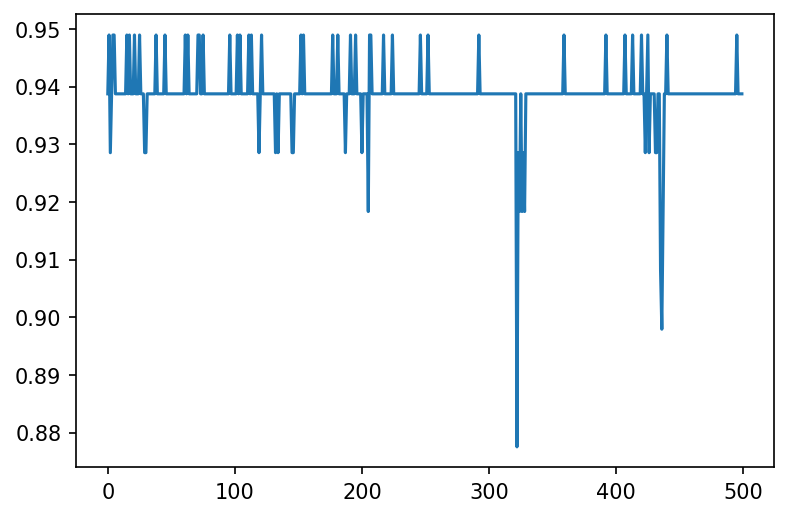

In [91]:
plt.figure(dpi=150)
plt.plot(hist.history['val_acc']);

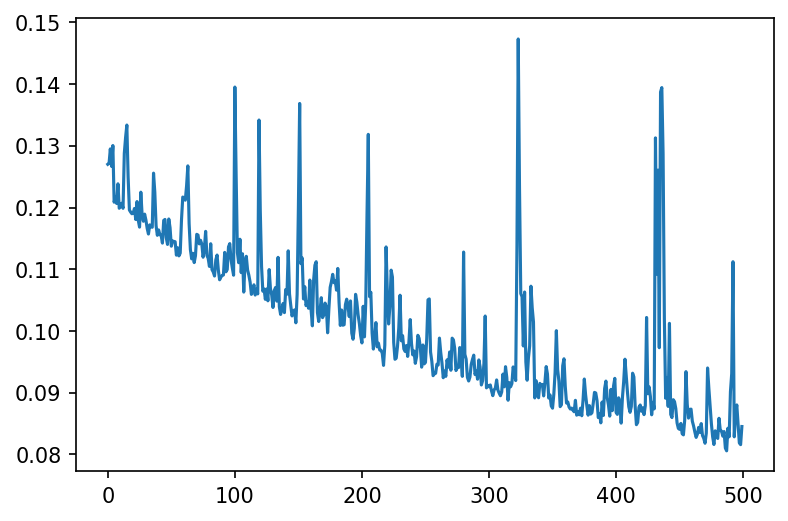

In [92]:
plt.figure(dpi=150)
plt.plot(hist.history['loss']);

In [62]:
preds = main_model.predict_classes(encoder(data.x_test))
preds = preds.squeeze()
metrics = ClassificationMetrics(data.y_test, preds)
metrics.add_metrics(['pd', 'pf', 'accuracy', 'f1'])
metrics.get_metrics()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


[0.7575757575757576,
 0.12307692307692308,
 0.8367346938775511,
 0.7575757575757576]

Can we train further?

In [63]:
hist = main_model.fit(encoded, data.y_train, epochs=500)

Epoch 1/500
10/10 [==============================] - 0s 4ms/step - loss: 0.3832 - acc: 0.8265
Epoch 2/500
10/10 [==============================] - 0s 4ms/step - loss: 0.3840 - acc: 0.8299
Epoch 3/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3832 - acc: 0.8231
Epoch 4/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3829 - acc: 0.8231
Epoch 5/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3831 - acc: 0.8265
Epoch 6/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3832 - acc: 0.8265
Epoch 7/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3822 - acc: 0.8265
Epoch 8/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3829 - acc: 0.8367
Epoch 9/500
10/10 [==============================] - 0s 6ms/step - loss: 0.3821 - acc: 0.8333
Epoch 10/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3830 - acc: 0.8197
Epoch 11/500
10/10 [==============================] - 0s 3m

10/10 [==============================] - 0s 2ms/step - loss: 0.3801 - acc: 0.8333
Epoch 172/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3799 - acc: 0.8299
Epoch 173/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3797 - acc: 0.8299
Epoch 174/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3798 - acc: 0.8197
Epoch 175/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3800 - acc: 0.8197
Epoch 176/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3795 - acc: 0.8197
Epoch 177/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3798 - acc: 0.8299
Epoch 178/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3800 - acc: 0.8333
Epoch 179/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3820 - acc: 0.8265
Epoch 180/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3794 - acc: 0.8299
Epoch 181/500
10/10 [==============================] -

10/10 [==============================] - 0s 2ms/step - loss: 0.3773 - acc: 0.8367
Epoch 342/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3796 - acc: 0.8129
Epoch 343/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3783 - acc: 0.8163
Epoch 344/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3771 - acc: 0.8435
Epoch 345/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3779 - acc: 0.8299
Epoch 346/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3779 - acc: 0.8367
Epoch 347/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3769 - acc: 0.8333
Epoch 348/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3768 - acc: 0.8333
Epoch 349/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3772 - acc: 0.8401
Epoch 350/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3772 - acc: 0.8299
Epoch 351/500
10/10 [==============================] -

In [64]:
preds = main_model.predict_classes(encoder(data.x_test))
preds = preds.squeeze()
metrics = ClassificationMetrics(data.y_test, preds)
metrics.add_metrics(['pd', 'pf', 'accuracy', 'f1'])
metrics.get_metrics()

[0.7575757575757576,
 0.1076923076923077,
 0.8469387755102041,
 0.7692307692307692]

## DODGE on autoencoder outputs

In [109]:
data2 = Data(x_train=encoder(data.x_train), 
             x_test=encoder(data.x_test), 
             y_train=data.y_train, 
             y_test=data.y_test)

In [114]:
config = {
    "n_runs": 20,
    "transforms": ["standardize"] * 50,
    "metrics": ["accuracy", "d2h", "pd", "pf", "auc"],
    "random": True,
    "learners": [],
    "log_path": "./",
    "data": [data],
    "name": "dataclass"
}
for _ in range(50):
    config["learners"].extend([DecisionTree(random=True), RandomForest(random=True), LogisticRegressionClassifier(random=True), NaiveBayes(random=True)])

In [115]:
dodge = DODGE(config)
dodge.optimize()

{'hooks': None, 'learner': DecisionTreeClassifier(splitter='random'), 'name': 'rf', 'random': True, 'random_map': {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random']}, 'x_test': None, 'x_train': None, 'y_test': None, 'y_train': None}
{'hooks': None, 'learner': RandomForestClassifier(), 'name': 'rf', 'random': True, 'random_map': {'criterion': ['gini', 'entropy'], 'n_estimators': (10, 100)}, 'x_test': None, 'x_train': None, 'y_test': None, 'y_train': None}
{'hooks': None, 'learner': LogisticRegression(C=10.0, solver='liblinear'), 'name': 'rf', 'random': True, 'random_map': {'penalty': ['l1', 'l2'], 'C': [0.1, 1.0, 10.0, 100.0, 1000.0]}, 'x_test': None, 'x_train': None, 'y_test': None, 'y_train': None}
{'hooks': None, 'learner': GaussianNB(), 'name': 'rf', 'random': True, 'random_map': {}, 'x_test': None, 'x_train': None, 'y_test': None, 'y_train': None}
{'hooks': None, 'learner': DecisionTreeClassifier(splitter='random'), 'name': 'rf', 'random': True, 'random_map': {'crite

standardizec|rf
1
standardizea|rf
2
standardizeE|rf
3
standardizet|rf
4
standardizex|rf
5
standardizeM|rf
6
standardizen|rf
7
standardizeo|rf
8
standardizeL|rf
9
standardizel|rf
10
standardizeF|rf
11
standardizeR|rf
12
standardizeG|rf
13
standardizeq|rf
14
standardizey|rf
15
standardizeg|rf
16
standardizee|rf
17
standardizep|rf
18
standardizeB|rf
19
standardizeZ|rf
20
standardizev|rf
21
standardizeY|rf
22
standardizeA|rf
23
standardizeK|rf
24
standardizeJ|rf
25
standardizes|rf
26
standardizeH|rf
27
standardizeN|rf
28
standardizek|rf
29
standardizew|rf
0
standardizeX|rf
1
standardizeR|rf
2
standardizen|rf
3
standardizeL|rf
4
standardizeP|rf
5
standardizeY|rf
6
standardizeK|rf
7
standardizez|rf
8
standardizew|rf
9
standardizea|rf
10
standardizeT|rf
11
standardizeH|rf
12
standardizeV|rf
13
standardizeu|rf
14
standardizeJ|rf
15
standardizeS|rf
16
standardizel|rf
17
standardizee|rf
18
standardizet|rf
19
standardizeZ|rf
20
standardizex|rf
21
standardizeO|rf
22
standardizec|rf
23
standardizeN

standardizeK|rf
21
standardizeh|rf
22
standardizeB|rf
23
standardizeI|rf
24
standardizea|rf
25
standardizez|rf
26
standardizeJ|rf
27
standardizey|rf
28
standardizes|rf
29
standardizeC|rf
0
standardizet|rf
1
standardizeh|rf
2
standardizeS|rf
3
standardizeM|rf
4
standardizeO|rf
5
standardizeA|rf
6
standardizeG|rf
7
standardizeB|rf
8
standardizeI|rf
9
standardizez|rf
10
standardizeQ|rf
11
standardizeK|rf
12
standardizef|rf
13
standardizeV|rf
14
standardizes|rf
15
standardizec|rf
16
standardizeH|rf
17
standardizeW|rf
18
standardizen|rf
19
standardizeY|rf
20
standardizeE|rf
21
standardizeX|rf
22
standardizea|rf
23
standardizer|rf
24
standardizeJ|rf
25
standardizeg|rf
26
standardizeT|rf
27
standardizeD|rf
28
standardizem|rf
29
standardizeb|rf
0
standardizeY|rf
1
standardizek|rf
2
standardizeZ|rf
3
standardizeX|rf
4
standardizeh|rf
5
standardizex|rf
6
standardizeb|rf
7
standardizeS|rf
8
standardizeR|rf
9
standardizet|rf
10
standardizez|rf
11
standardizej|rf
12
standardizeE|rf
13
standardizew|

In [116]:
from raise_utils.interpret import DODGEInterpreter

In [117]:
interp = DODGEInterpreter(files=['./dataclass.txt'], max_by=0, metrics=["accuracy", "d2h", "pd", "pf", "auc"])

In [118]:
interp.interpret()

{'dataclass.txt': {'accuracy': array([1.        , 1.        , 1.        , 1.        , 1.        ,
         0.98979592, 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ]),
  'd2h': array([0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
         0.68746493, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
         0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
         0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678]),
  'pd': array([1.        , 1.        , 1.        , 1.        , 1.        ,
         0.97222222, 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ]),
  'pf': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]),
  'auc': array([1.